# Fake News Detection

## Exploratory Data Analysis

***
The datasets used in this project are open source and freely available online. The data includes both fake and truthful news articles from multiple domains. The truthful news articles published contain true description of real world events, while the fake news websites contain claims that are not aligned with facts. The conformity of claims from the politics domain for many of those articles can be manually checked with fact checking websites such as politifact.com and snopes.com. I have used three different datasets here:

- The first dataset is called the “ISOT Fake News Dataset” (ds_1) which contains both true and fake articles extracted from the World Wide Web. The true articles are extracted from reuters.com which is a re-nowned news website, while the fake articles were extracted from multiple sources, mostly websites which are flagged by politifact.com. The dataset contains a total of 44,898 articles, out of which 21,417 are truthful articles and 23,481 fake articles. The total corpora contain articles from different domains, but most prominently target political news.
- The second dataset is available at Kaggle (ds_2) and contains a total of 20,386 articles used for training and 5,126 articles used for testing. The dataset is built from multiple sources on the Internet. The articles are not limited to a single domain such as politics as they include both fake and true articles from various other domains.
- The third dataset is also available at Kaggle (ds_3) and includes a total of 3,352 articles, both fake and true. The true articles are extracted from trusted online sources such as CNN, Reuters, the New York Times, and various others, while the fake news articles are extracted from untrusted news websites. The domains it covered include sports, entertainment, and politics.

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
import multiprocessing
import time

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
# !pip install emoji
# !pip install bs4
from bs4 import BeautifulSoup

from wordcloud import WordCloud 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to /Users/laura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/laura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laura/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


First let's take a quick look at the data.

In [2]:
true = pd.read_csv('data/True.csv')
fake = pd.read_csv('data/Fake.csv')

In [3]:
true['label'] = 0
fake['label'] = 1

In [4]:
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the N...",politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online r...",politicsNews,"December 29, 2017",0


In [5]:
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,News,"December 25, 2017",1


In [6]:
ds_1 = pd.concat([true , fake])

In [7]:
ds_1.shape

(44898, 5)

In [8]:
ds_1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 149.8 MB


In [9]:
ds_1.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the N...",politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online r...",politicsNews,"December 29, 2017",0


In [10]:
ds_2 = pd.read_csv('data/train.csv')

In [11]:
ds_2.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy...",1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Welle...",0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the l...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the...,1
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Guard searched her home and found a notebook that contained a fictional story she’d written about a wo...,1


In [12]:
ds_2.shape

(20800, 5)

In [13]:
ds_2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 186.5 MB


In [14]:
ds_3 = pd.read_csv('data/data.csv')

In [15]:
ds_3.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-41419190\r\n,Four ways Bob Corker skewered Donald Trump,"Image copyright Getty Images\nOn Sunday morning, Donald Trump went off on a Twitter tirade against a member of his own party.\nThis, in itself, isn't exactly huge news. It's far from the first tim...",1
1,https://www.reuters.com/article/us-filmfestival-london-lastflagflying/linklaters-war-veteran-comedy-speaks-to-modern-america-says-star-idUSKBN1CD0X2\r\n,"Linklater's war veteran comedy speaks to modern America, says star","LONDON (Reuters) - “Last Flag Flying”, a comedy-drama about Vietnam war veterans, will resonate with Trump’s America, despite, or perhaps because of, its period setting, actor Bryan Cranston said ...",1
2,https://www.nytimes.com/2017/10/09/us/politics/corkers-blast-at-trump-has-other-republicans-nodding-in-agreement.html?rref=collection%2Fsectioncollection%2Fpolitics\r\n,Trump’s Fight With Corker Jeopardizes His Legislative Agenda,The feud broke into public view last week when Mr. Corker said that Mr. Trump’s advisers were guarding against “chaos.” The president retaliated on Sunday by saying the retiring senator “didn’t ha...,1
3,https://www.reuters.com/article/us-mexico-oil-cardenas/egypts-cheiron-wins-tie-up-with-pemex-for-mexican-onshore-oil-field-idUSKBN1C92EU\r\n,Egypt's Cheiron wins tie-up with Pemex for Mexican onshore oil field,"MEXICO CITY (Reuters) - Egypt’s Cheiron Holdings Limited won the rights to partner with Mexican national oil company Pemex on its onshore Cardenas-Mora project, the industry regulator said on Wedn...",1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/snl-jason-aldean-las-vegas-tom-petty-orig.cnn/video/playlists/cant-miss/\n,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performing as the Las Vegas shooting began, did the ""Saturday Night Live"" cold open with a tribute to the victims and their families by singing Tom Petty's ""I ...",1


In [16]:
ds_3.shape

(4009, 4)

In [17]:
ds_3.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 21.7 MB


In [18]:
ds_4 = pd.read_csv('data/news.csv')

In [19]:
ds_4.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to wa...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will ne...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,"U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerr...",REAL
3,10142,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People F...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners Hillary Clinton and Donald Trump are leading in the polls.\n\nTrump is now vowing to win enough delegates to clinch the Republican nomination and pre...,REAL


In [20]:
ds_4.shape

(6335, 4)

In [21]:
ds_4.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 54.8 MB


The columns in the datasets do not match entirely, so let's deal with that and merge everything into one dataset.

In [22]:
ds_1 = ds_1[['text','label']]
ds_2 = ds_2[['text','label']]

In [23]:
ds_3.rename(columns = {'Headline':'title', 'Body':'text',
                              'Label':'label'}, inplace = True)

In [24]:
ds_3 = ds_3[['text', 'label']]

In [25]:
ds_4['label'] = ds_4['label'].map({'FAKE': 1, 'REAL': 0})

In [26]:
ds_4 = ds_4[['text', 'label']]

In [27]:
df = pd.concat([ds_1 , ds_2, ds_3, ds_4])

In [28]:
df.head()

,text,label
0,"WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",0
1,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",0
2,"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",0
3,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the N...",0
4,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online r...",0


In [29]:
df.shape

(76042, 2)

In [30]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76042 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    75982 non-null  object
 1   label   76042 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 392.3 MB


In [31]:
df.isnull().sum() # null values

text     60
label     0
dtype: int64

In [32]:
df = df.dropna(how='any',axis=0) 

In [33]:
df.isnull().sum() # no null values

text     0
label    0
dtype: int64

In [34]:
df['label'].value_counts()

1    38887
0    37095
Name: label, dtype: int64

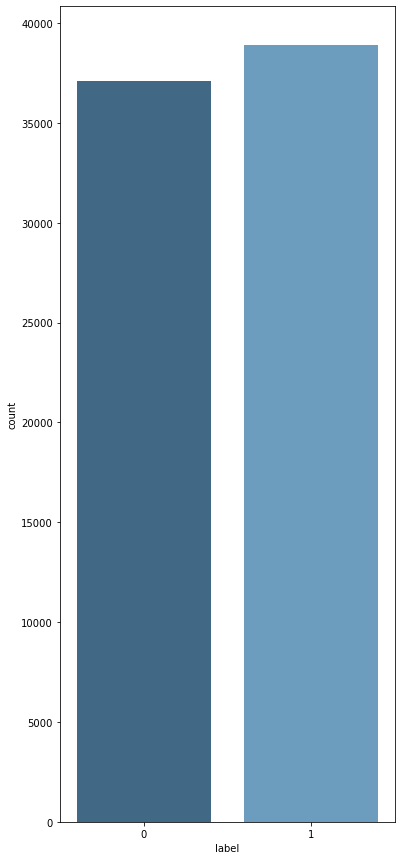

In [35]:
f, ax = plt.subplots(figsize=(6, 15))
ax = sns.countplot(x="label", data=df, palette='Blues_d')

**Data cleaning**

In order to clean the data, we’ll perform the following actions:
- remove punctuations
- remove digits
- remove stopwords
- remove http/https links
- expand contractions 
- apply lemmatization.

For removing punctuations, I'll use Python's constant called string.punctuation that provides already a list of punctuation characters.

Stop words are those words that do not add a deeper meaning to the phrase. They are the most common words such as: “the“, “a“, and “is“. For our application, it makes sense to remove stop words, since they typically  do not convey sentiments. NLTK provides a list of commonly agreed upon stop words for English, so I'll use that. 

Stemming is the process of converting the words of a sentence to its non-changing portions. For example "trying", "trial", and "tried", the stem would be "tri". I've tried PorterStemmer for this part, but was not very happy with the result, so I will not apply stemming here.

Lemmatization is the process of converting the words of a sentence to its dictionary form. For example, given the words "trying", "trial", and "tried", the lemma for each and all would be "try". Once again I'll use NLTK which has a great built in lemmatizer.

I've experimented with different python libraries for contractions, but was unsuccessful, so I've decided to write my own function. I've used this article as inspiration but simplified the contraction expansion using match.
https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py

In [36]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [37]:
contractions_re = re.compile('(%s)' % '|'.join(CONTRACTION_MAP.keys()))
def expand_contractions(s, CONTRACTION_MAP=CONTRACTION_MAP):
    def replace(match):
            return CONTRACTION_MAP[match.group(0)]
    return contractions_re.sub(replace, s)

In [38]:
# expand contractions
df["text"] = df['text'].apply(lambda x: expand_contractions(x))
df.head(10)

,text,label
0,"WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",0
1,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",0
2,"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",0
3,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the N...",0
4,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online r...",0
5,"WEST PALM BEACH, Fla./WASHINGTON (Reuters) - The White House said on Friday it was set to kick off talks next week with Republican and Democratic congressional leaders on immigration policy, gover...",0
6,"WEST PALM BEACH, Fla (Reuters) - President Donald Trump said on Thursday he believes he will be fairly treated in a special counsel investigation into Russian meddling in the U.S. presidential ele...",0
7,"The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the s...",0
8,"The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the s...",0
9,"WASHINGTON (Reuters) - Alabama Secretary of State John Merrill said he will certify Democratic Senator-elect Doug Jones as winner on Thursday despite opponent Roy Moore’s challenge, in a phone cal...",0


In [39]:
df = df.dropna(how='any',axis=0) 

In [40]:
# remove stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if (word not in stop_words)]))
df.head()

,text,label
0,"WASHINGTON (Reuters) - The head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 201...",0
1,"WASHINGTON (Reuters) - Transgender people allowed first time enlist U.S. military starting Monday ordered federal courts, Pentagon said Friday, President Donald Trump’s administration decided appe...",0
2,"WASHINGTON (Reuters) - The special counsel investigation links Russia President Trump’s 2016 election campaign continue without interference 2018, despite calls Trump administration allies Republi...",0
3,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told Australian diplomat May 2016 Russia political dirt Democratic presidential candidate Hillary Clinton, New York Times reported...",0
4,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called U.S. Postal Service Friday charge “much more” ship packages Amazon (AMZN.O), picking another fight online retail giant criticized past....",0


In [41]:
df = df.dropna(how='any',axis=0) 

In [42]:
# remove html formatting, if any other left
def remove_tags(row):
    if row is None:
            return None
    else:
            return ''.join(BeautifulSoup(row).findAll(text=True)) 

In [43]:
df['text'] = df['text'].apply(lambda x: remove_tags(x))
df.head()

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://www.youtube.com/watch?v=cJZFepSvxzM" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://www.youtube.com/watch?v=-7Tn4gi_Os8" looks like a URL. Beautiful Sou

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://www.youtube.com/watch?v=HXJZbPAf0sk" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://www.youtube.com/watch?feature=player_embedded&v=JebHe3049aA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://www.youtube.com/watch?v=sWbYpIj7CQ8" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests 

,text,label
0,"WASHINGTON (Reuters) - The head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 201...",0
1,"WASHINGTON (Reuters) - Transgender people allowed first time enlist U.S. military starting Monday ordered federal courts, Pentagon said Friday, President Donald Trump’s administration decided appe...",0
2,"WASHINGTON (Reuters) - The special counsel investigation links Russia President Trump’s 2016 election campaign continue without interference 2018, despite calls Trump administration allies Republi...",0
3,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told Australian diplomat May 2016 Russia political dirt Democratic presidential candidate Hillary Clinton, New York Times reported...",0
4,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called U.S. Postal Service Friday charge “much more” ship packages Amazon (AMZN.O), picking another fight online retail giant criticized past....",0


In [44]:
# remove punctuation
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df.head()

,text,label
0,WASHINGTON Reuters The head conservative Republican faction US Congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” Sunday urged budget restraint 2018 In ke...,0
1,WASHINGTON Reuters Transgender people allowed first time enlist US military starting Monday ordered federal courts Pentagon said Friday President Donald Trump’s administration decided appeal ruli...,0
2,WASHINGTON Reuters The special counsel investigation links Russia President Trump’s 2016 election campaign continue without interference 2018 despite calls Trump administration allies Republican ...,0
3,WASHINGTON Reuters Trump campaign adviser George Papadopoulos told Australian diplomat May 2016 Russia political dirt Democratic presidential candidate Hillary Clinton New York Times reported Sat...,0
4,SEATTLEWASHINGTON Reuters President Donald Trump called US Postal Service Friday charge “much more” ship packages Amazon AMZNO picking another fight online retail giant criticized past “Why Unite...,0


In [45]:
df = df.dropna(how='any',axis=0) 

In [46]:
# remove digits
df['text'] = df['text'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df.head()

,text,label
0,WASHINGTON Reuters The head conservative Republican faction US Congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” Sunday urged budget restraint In keepin...,0
1,WASHINGTON Reuters Transgender people allowed first time enlist US military starting Monday ordered federal courts Pentagon said Friday President Donald Trump’s administration decided appeal ruli...,0
2,WASHINGTON Reuters The special counsel investigation links Russia President Trump’s election campaign continue without interference despite calls Trump administration allies Republican lawmaker...,0
3,WASHINGTON Reuters Trump campaign adviser George Papadopoulos told Australian diplomat May Russia political dirt Democratic presidential candidate Hillary Clinton New York Times reported Saturda...,0
4,SEATTLEWASHINGTON Reuters President Donald Trump called US Postal Service Friday charge “much more” ship packages Amazon AMZNO picking another fight online retail giant criticized past “Why Unite...,0


In [47]:
df = df.dropna(how='any',axis=0) 

In [48]:
# remove special (all non-ASCII) characters
# characters are 8 byte (0-255), ascii chars are 7 byte (0-127), so we simply drop all chars with a ord value below 128

df['text'] = df['text'].apply(lambda x: ''.join((c for c in str(x) if ord(c) < 128)))
df.head()

,text,label
0,WASHINGTON Reuters The head conservative Republican faction US Congress voted month huge expansion national debt pay tax cuts called fiscal conservative Sunday urged budget restraint In keeping ...,0
1,WASHINGTON Reuters Transgender people allowed first time enlist US military starting Monday ordered federal courts Pentagon said Friday President Donald Trumps administration decided appeal rulin...,0
2,WASHINGTON Reuters The special counsel investigation links Russia President Trumps election campaign continue without interference despite calls Trump administration allies Republican lawmakers...,0
3,WASHINGTON Reuters Trump campaign adviser George Papadopoulos told Australian diplomat May Russia political dirt Democratic presidential candidate Hillary Clinton New York Times reported Saturda...,0
4,SEATTLEWASHINGTON Reuters President Donald Trump called US Postal Service Friday charge much more ship packages Amazon AMZNO picking another fight online retail giant criticized past Why United S...,0


In [49]:
df = df.dropna(how='any',axis=0) 

In [50]:
# stemming
# ps = PorterStemmer()
# df['stemmed_text'] = df['text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() ]))
# df.head()

In [51]:
# lemmatization
wnlmtz = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([wnlmtz.lemmatize(word,'v') for word in x.split() ]))
df.head()

,text,label
0,WASHINGTON Reuters The head conservative Republican faction US Congress vote month huge expansion national debt pay tax cut call fiscal conservative Sunday urge budget restraint In keep sharp pivo...,0
1,WASHINGTON Reuters Transgender people allow first time enlist US military start Monday order federal court Pentagon say Friday President Donald Trumps administration decide appeal rule block trans...,0
2,WASHINGTON Reuters The special counsel investigation link Russia President Trumps election campaign continue without interference despite call Trump administration ally Republican lawmakers shut d...,0
3,WASHINGTON Reuters Trump campaign adviser George Papadopoulos tell Australian diplomat May Russia political dirt Democratic presidential candidate Hillary Clinton New York Times report Saturday Th...,0
4,SEATTLEWASHINGTON Reuters President Donald Trump call US Postal Service Friday charge much more ship package Amazon AMZNO pick another fight online retail giant criticize past Why United States Po...,0


In [52]:
# remove single letters
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df.head()

,text,label
0,WASHINGTON Reuters The head conservative Republican faction US Congress vote month huge expansion national debt pay tax cut call fiscal conservative Sunday urge budget restraint In keep sharp pivo...,0
1,WASHINGTON Reuters Transgender people allow first time enlist US military start Monday order federal court Pentagon say Friday President Donald Trumps administration decide appeal rule block trans...,0
2,WASHINGTON Reuters The special counsel investigation link Russia President Trumps election campaign continue without interference despite call Trump administration ally Republican lawmakers shut d...,0
3,WASHINGTON Reuters Trump campaign adviser George Papadopoulos tell Australian diplomat May Russia political dirt Democratic presidential candidate Hillary Clinton New York Times report Saturday Th...,0
4,SEATTLEWASHINGTON Reuters President Donald Trump call US Postal Service Friday charge much more ship package Amazon AMZNO pick another fight online retail giant criticize past Why United States Po...,0


In [53]:
# one last check to see if the data cleaning hasn't completely removed all the words in some of the rows with very few words
df = df.dropna(how='any',axis=0) 

In [54]:
# to lower case
df["text"] = df["text"].str.lower()
df.head()

,text,label
0,washington reuters the head conservative republican faction us congress vote month huge expansion national debt pay tax cut call fiscal conservative sunday urge budget restraint in keep sharp pivo...,0
1,washington reuters transgender people allow first time enlist us military start monday order federal court pentagon say friday president donald trumps administration decide appeal rule block trans...,0
2,washington reuters the special counsel investigation link russia president trumps election campaign continue without interference despite call trump administration ally republican lawmakers shut d...,0
3,washington reuters trump campaign adviser george papadopoulos tell australian diplomat may russia political dirt democratic presidential candidate hillary clinton new york times report saturday th...,0
4,seattlewashington reuters president donald trump call us postal service friday charge much more ship package amazon amzno pick another fight online retail giant criticize past why united states po...,0


In [55]:
cumulative_sum = {}

for x in df["text"].values:
    cumulative_sum.update(dict.fromkeys(set(x.lower().split())))

In [56]:
print(len(cumulative_sum))

332455


The size of the corpus seems to be big enough for the next steps.

In [57]:
# change the datatype of the text column
df = df.astype({'text': np.str})

In [58]:
# save the dataframe to a new file
df.to_csv('dataset_cleaned.csv', index = False, encoding='utf-8-sig')

In [59]:
df = pd.read_csv('dataset_cleaned.csv', encoding='utf-8-sig', engine='python')

**Analysis of the full text comments**


I will start by computing some basic statistics on the comments.

**Number of characters**

First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the words and texts length.

In [60]:
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
df[['text','char_count']].head(10)

,text,char_count
0,washington reuters the head conservative republican faction us congress vote month huge expansion national debt pay tax cut call fiscal conservative sunday urge budget restraint in keep sharp pivo...,3276
1,washington reuters transgender people allow first time enlist us military start monday order federal court pentagon say friday president donald trumps administration decide appeal rule block trans...,2963
2,washington reuters the special counsel investigation link russia president trumps election campaign continue without interference despite call trump administration ally republican lawmakers shut d...,1955
3,washington reuters trump campaign adviser george papadopoulos tell australian diplomat may russia political dirt democratic presidential candidate hillary clinton new york times report saturday th...,1758
4,seattlewashington reuters president donald trump call us postal service friday charge much more ship package amazon amzno pick another fight online retail giant criticize past why united states po...,3579
5,west palm beach flawashington reuters the white house say friday set kick talk next week republican democratic congressional leaders immigration policy government spend issue need wrap early new y...,2721
6,west palm beach fla reuters president donald trump say thursday believe fairly treat special counsel investigation russian meddle us presidential election say know long probe would last the federa...,2232
7,the follow statements post verify twitter account us president donald trump realdonaldtrump potus the opinions express own reuters edit statements confirm accuracy realdonaldtrump while fake news ...,566
8,the follow statements post verify twitter account us president donald trump realdonaldtrump potus the opinions express own reuters edit statements confirm accuracy realdonaldtrump together making ...,439
9,washington reuters alabama secretary state john merrill say certify democratic senatorelect doug jones winner thursday despite opponent roy moores challenge phone call cnn moore conservative face ...,308


In [61]:
df.sort_values(by='char_count', ascending=False).head()

,text,label,char_count
58401,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,1,85051
53602,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,1,76315
74380,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287
52414,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287
49979,reasons why california is the worst state in america december th why world would anyone want live state california point the entire state rapidly become bright shin example everything wrong americ...,1,65749


In [62]:
df.groupby('label')['char_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,37095.0,2366.403909,2219.974840,2.0,966.0,1838.0,3247.0,57608.0
1,38887.0,2097.260730,2703.586022,2.0,899.0,1506.0,2375.0,85051.0


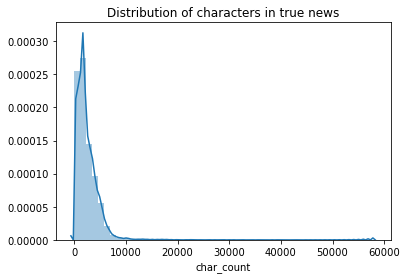

In [63]:
sns.distplot(df['char_count'][df['label']==0]).set_title("Distribution of characters in true news");

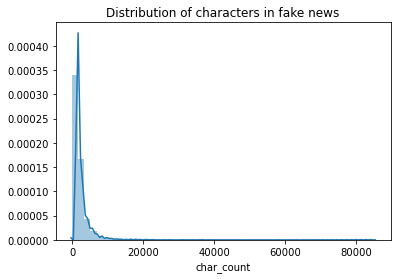

In [64]:
sns.distplot(df['char_count'][df['label']==1]).set_title("Distribution of characters in fake news");

**Number of words**

Now, we will move on to data exploration at a word-level.

In [65]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head(10)

,text,word_count
0,washington reuters the head conservative republican faction us congress vote month huge expansion national debt pay tax cut call fiscal conservative sunday urge budget restraint in keep sharp pivo...,460
1,washington reuters transgender people allow first time enlist us military start monday order federal court pentagon say friday president donald trumps administration decide appeal rule block trans...,393
2,washington reuters the special counsel investigation link russia president trumps election campaign continue without interference despite call trump administration ally republican lawmakers shut d...,276
3,washington reuters trump campaign adviser george papadopoulos tell australian diplomat may russia political dirt democratic presidential candidate hillary clinton new york times report saturday th...,236
4,seattlewashington reuters president donald trump call us postal service friday charge much more ship package amazon amzno pick another fight online retail giant criticize past why united states po...,510
5,west palm beach flawashington reuters the white house say friday set kick talk next week republican democratic congressional leaders immigration policy government spend issue need wrap early new y...,379
6,west palm beach fla reuters president donald trump say thursday believe fairly treat special counsel investigation russian meddle us presidential election say know long probe would last the federa...,332
7,the follow statements post verify twitter account us president donald trump realdonaldtrump potus the opinions express own reuters edit statements confirm accuracy realdonaldtrump while fake news ...,81
8,the follow statements post verify twitter account us president donald trump realdonaldtrump potus the opinions express own reuters edit statements confirm accuracy realdonaldtrump together making ...,63
9,washington reuters alabama secretary state john merrill say certify democratic senatorelect doug jones winner thursday despite opponent roy moores challenge phone call cnn moore conservative face ...,41


In [66]:
df.groupby('label')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,37095.0,339.455991,326.303385,1.0,137.0,258.0,464.0,8364.0
1,38887.0,298.682542,387.688286,1.0,130.0,216.0,338.0,13419.0


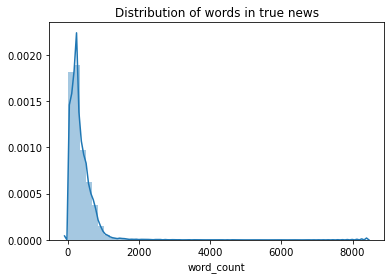

In [67]:
sns.distplot(df['word_count'][df['label']==0]).set_title("Distribution of words in true news");

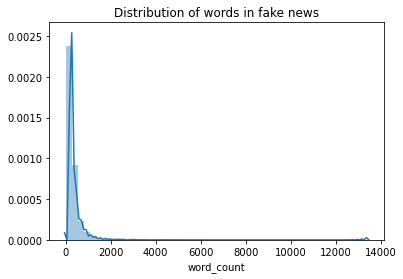

In [68]:
sns.distplot(df['word_count'][df['label']==1]).set_title("Distribution of words in fake news");

In [69]:
df = df.sort_values(['word_count'], ascending=False)
df[df['label'] == 1].head()

,text,label,char_count,word_count
58401,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,1,85051,13419
53602,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,1,76315,11720
52414,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584
74380,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584
47626,why is obama threatening russia with world war right before the election october th it sure seem like odd time provoke war russia as write this stand little bite three weeks away one pivotal elect...,1,64908,10261


**Average Word Length**

In [71]:
df['avg_word'] = df['text'].astype('str').apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
df[['text','avg_word']].head()

,text,avg_word
58401,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,5.338177
53602,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,5.511604
52414,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,5.412983
74380,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,5.412983
47626,why is obama threatening russia with world war right before the election october th it sure seem like odd time provoke war russia as write this stand little bite three weeks away one pivotal elect...,5.325797


**Sentence Length**

The length of the samples in the dataset is very important, as it can affect how we represent the text as features for the ML models. For example, TF-IDF is usually too sparse for short texts and average Word2Vec is usually too noisy for long texts.

In [72]:
df['avg_text'] = df['text'].astype('str').apply(lambda x: sum(len(word) for word in x.split()))
df[['text','avg_text']].head()

,text,avg_text
58401,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,71633
53602,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,64596
52414,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,62704
74380,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,62704
47626,why is obama threatening russia with world war right before the election october th it sure seem like odd time provoke war russia as write this stand little bite three weeks away one pivotal elect...,54648


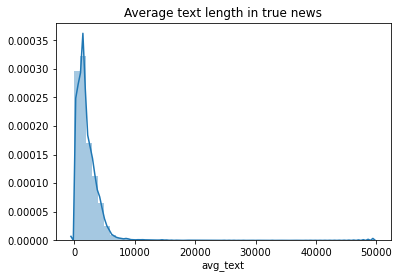

In [73]:
sns.distplot(df['avg_text'][df['label']==0]).set_title("Average text length in true news");

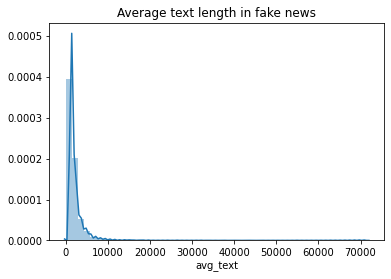

In [74]:
sns.distplot(df['avg_text'][df['label']==1]).set_title("Average text length in fake news");

Although some texts can to be lengthy, the vast majority of the texts are short. Also the fake news are typically shorter than real news.

**Most common words**

In [76]:
from collections import Counter
count_common = Counter(" ".join(df["text"].astype('str')).split()).most_common(100)

In [77]:
count_common

[('say', 310854),
 ('the', 257084),
 ('trump', 182103),
 ('would', 109743),
 ('us', 105755),
 ('people', 92353),
 ('one', 88804),
 ('it', 86442),
 ('president', 84745),
 ('make', 83541),
 ('state', 82602),
 ('go', 76164),
 ('mr', 74410),
 ('new', 74293),
 ('also', 68231),
 ('take', 67140),
 ('in', 67028),
 ('get', 63090),
 ('clinton', 63030),
 ('like', 60582),
 ('time', 60073),
 ('he', 57681),
 ('but', 53676),
 ('tell', 53646),
 ('could', 52353),
 ('know', 51279),
 ('come', 49585),
 ('this', 49425),
 ('government', 48799),
 ('house', 48498),
 ('call', 47955),
 ('even', 47657),
 ('use', 47648),
 ('campaign', 46426),
 ('work', 45846),
 ('two', 45340),
 ('and', 44626),
 ('obama', 44194),
 ('first', 44070),
 ('we', 43868),
 ('think', 43737),
 ('last', 43702),
 ('many', 43288),
 ('see', 42900),
 ('report', 42872),
 ('united', 42765),
 ('years', 42516),
 ('donald', 42389),
 ('vote', 42334),
 ('want', 41852),
 ('news', 41611),
 ('party', 40428),
 ('include', 40415),
 ('white', 40122),
 ('righ

**Most rare words**

In [78]:
from collections import Counter
count_rare = Counter(" ".join(df["text"].astype('str')).split()).most_common()[-2000:]

In [79]:
count_rare

[('brllt', 1),
 ('parfmerieschaufenster', 1),
 ('oberhand', 1),
 ('kannibale', 1),
 ('sichert', 1),
 ('zuchthaus', 1),
 ('verurteilter', 1),
 ('genforscher', 1),
 ('fortsetzen', 1),
 ('pupatt', 1),
 ('furzt', 1),
 ('trompete', 1),
 ('nymphomanin', 1),
 ('zwingt', 1),
 ('klebt', 1),
 ('studentenstreichen', 1),
 ('tomtsc', 1),
 ('klioga', 1),
 ('speciliased', 1),
 ('swampclear', 1),
 ('decksthrow', 1),
 ('outclean', 1),
 ('warlook', 1),
 ('brissago', 1),
 ('insteadharrison', 1),
 ('happenedharrison', 1),
 ('teaotia', 1),
 ('pictwittercomuvzldfzh', 1),
 ('sevenay', 1),
 ('dianea', 1),
 ('httpstcoqenisuyn', 1),
 ('manvote', 1),
 ('crellritus', 1),
 ('highyet', 1),
 ('skytruths', 1),
 ('smallyou', 1),
 ('scopeyet', 1),
 ('hopethat', 1),
 ('skyto', 1),
 ('crynot', 1),
 ('fearwhat', 1),
 ('dearthat', 1),
 ('fastsuch', 1),
 ('bedream', 1),
 ('passwhen', 1),
 ('faceautomatic', 1),
 ('heberling', 1),
 ('whgovlaipqh', 1),
 ('kindertransports', 1),
 ('strategistthe', 1),
 ('officecuban', 1),
 ('di

We can safely remove them, since none of them is an actual word (mostly misspellings, and probably hashtags).

In [80]:
# count_rare_list = list(count_rare.index)
df['text'] = df['text'].astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in count_rare))
df.head()

,text,label,char_count,word_count,avg_word,avg_text
58401,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,1,85051,13419,5.338177,71633
53602,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,1,76315,11720,5.511604,64596
52414,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584,5.412983,62704
74380,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584,5.412983,62704
47626,why is obama threatening russia with world war right before the election october th it sure seem like odd time provoke war russia as write this stand little bite three weeks away one pivotal elect...,1,64908,10261,5.325797,54648


In [96]:
# save the dataframe to a new file
df.to_csv('dataset_cleaned.csv', index = False, encoding='utf-8-sig')

**Most common fake/real words**

**Visualizations:**
- What are the most common words in the entire dataset?
- What are the most common words in the dataset for fake and real news, respectively?

Wordcloud is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

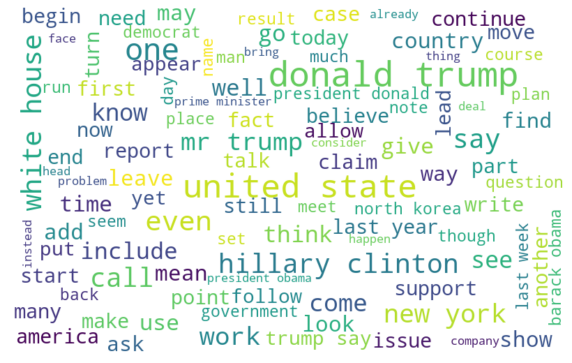

In [97]:
all_news =' '.join([text for text in df['text']]) 
wordcloud = WordCloud(width=800, height=500, max_font_size=50, max_words=100,background_color="white").generate(all_news) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

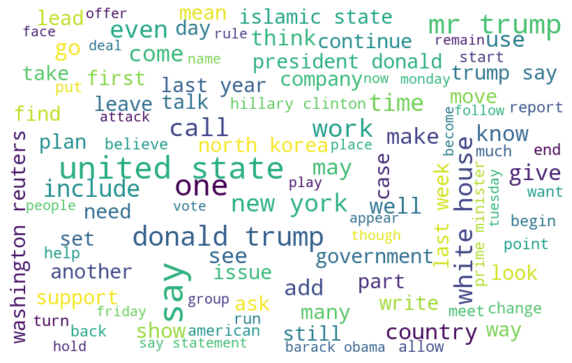

In [98]:
real_news =' '.join([text for text in df['text'][df['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, max_font_size=50, max_words=100,background_color="white").generate(real_news) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

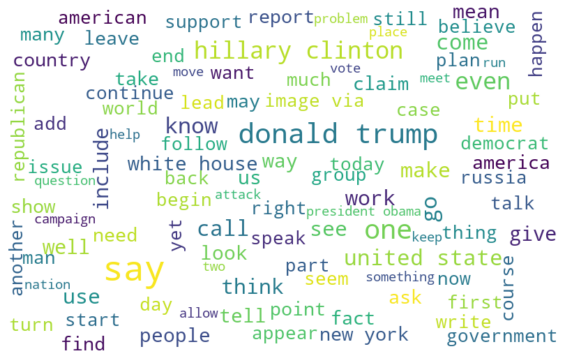

In [99]:
fake_news =' '.join([text for text in df['text'][df['label'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, max_font_size=50, max_words=100,background_color="white").generate(fake_news) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [100]:
top_fake = pd.Series(' '.join(df['text'][df['label'] == 1]).split()).value_counts()[:50]

In [101]:
df_f = pd.DataFrame(top_fake).reset_index()
df_f.columns = ['word', 'count']
df_f['label'] = '1'

In [102]:
top_real = pd.Series(' '.join(df['text'][df['label'] == 0]).split()).value_counts()[:50]

In [103]:
df_r = pd.DataFrame(top_real).reset_index()
df_r.columns = ['word', 'count']
df_r['label'] = '0'

In [104]:
stack = pd.concat([df_f, df_r], axis=0)

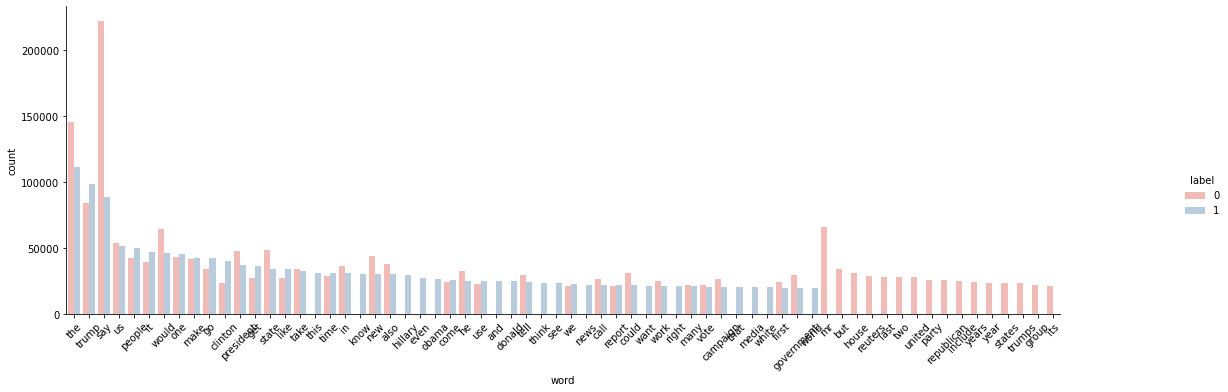

In [105]:
sns.set_palette("Pastel1")
g = sns.catplot(x='word', y='count', hue='label', data=stack, kind='bar')
g.fig.set_figwidth(20)
g.fig.set_figheight(5)
g.set_xticklabels(rotation=45)

Unfortunately, what we see here is that for a vast majority of the top 50 words there is no clear separation between the classes. 

**Topics**

The Gensim package is specialized in topic modeling. A topic model is a type of statistical model for discovering the abstract “topics” that occur in a collection of documents.
I will now try to extract topics using LDA (Latent Dirichlet Allocation): a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. Basically, documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words.

In [106]:
RANDOM_STATE = 12

In [107]:
fake_texts = df['text'][df['label'] == 1]

In [108]:
wpt = nltk.WordPunctTokenizer()
tokenized_texts = [wpt.tokenize(text) for text in fake_texts]

We remove rare words and common words based on their document frequency. Below we remove words that appear in less than 20 documents or in more than 50% of the documents.

In [109]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(tokenized_texts)

# Filter out words that occur less than 20 documents, or more than 80% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.8)

Finally, we transform the documents to a vectorized form. We simply compute the frequency of each word, including the bigrams.

In [110]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [111]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 19804
Number of documents: 38887


In [112]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters (as per gensim tutorial).
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [113]:
# get the output
list_dics = []
for i in range(0,10):
    list_tuples = model.get_topic_terms(i)
    for tpl in list_tuples:
        list_dics.append({"topic":i, "id":tpl[0], 
                         "word":id2word[tpl[0]], 
                         "weight":tpl[1]})
df_topics = pd.DataFrame(list_dics, columns=['topic','id','word','weight'])

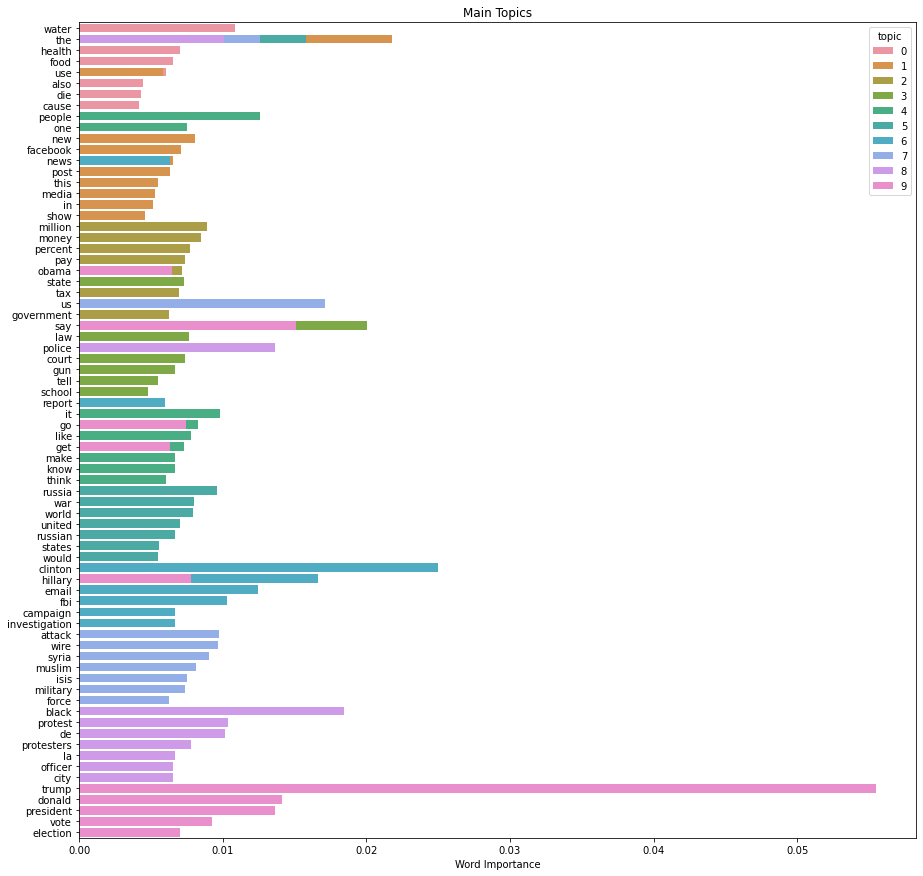

In [114]:
# plot
sns.set_palette("Pastel1")
fig, ax = plt.subplots(1,1,figsize=(15,15))
sns.barplot(y = "word", x = "weight", hue = "topic", data = df_topics, dodge = False, ax = ax).set_title('Main Topics')
ax.set(ylabel = "", xlabel = "Word Importance")
plt.show()

Here again, as in the previous cases, we see that there is no clear separation between the topics. Words belong to multiple topics.

In [3]:
df = pd.read_csv('dataset_cleaned.csv')

In [4]:
df.head()

,text,label,char_count,word_count,avg_word,avg_text
0,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,1,85051,13419,5.338177,71633
1,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,1,76315,11720,5.511604,64596
2,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584,5.412983,62704
3,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584,5.412983,62704
4,why is obama threatening russia with world war right before the election october th it sure seem like odd time provoke war russia as write this stand little bite three weeks away one pivotal elect...,1,64908,10261,5.325797,54648


In [5]:
df = df[df["text"].str.contains("nan")==False]

In [6]:
df = df[df["text"].str.contains("http")==False]

In [7]:
df = df[df["text"].str.contains("https")==False]

In [8]:
df.shape

(54283, 6)

In [9]:
# save the dataframe to a new file
df.to_csv('dataset_cleaned.csv', index = False, encoding='utf-8-sig')